----- Summary of Results -----
File: results/hellaswag_results_gpt2.json
Mean Capability (Accuracy): 0.067
Mean Entropy: 0.107
--------------------------------


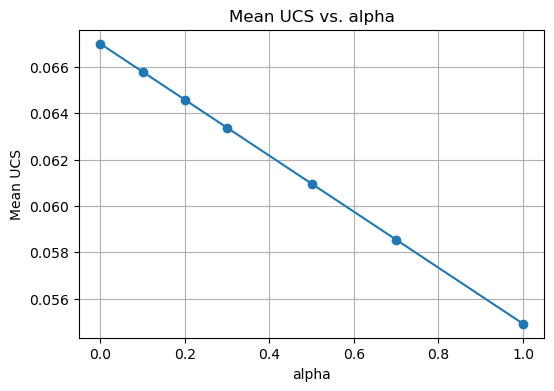

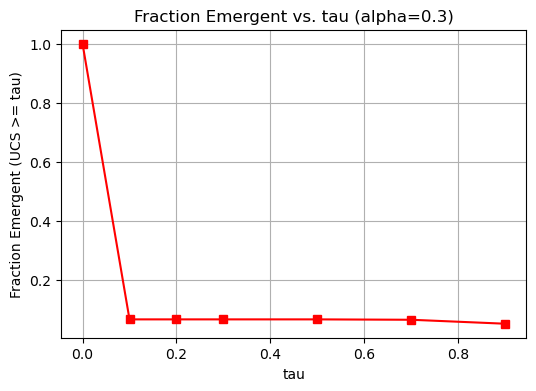


---- Table-Like Summary (alpha=0.3) ----
Mean Capability: 0.067
Mean Entropy   : 0.107
Mean UCS       : 0.063
----------------------------------------


In [2]:
#!/usr/bin/env python
# coding: utf-8

# 1. Imports & Setup
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# If you want to produce inline plots in a notebook:
# %matplotlib inline

###############################################################################
# 2. Utility Functions
###############################################################################

def load_results(json_path):
    """
    Loads the JSON results from your pipeline.
    Expects each item to have fields like:
      - capability: float (0 or 1 if a single question)
      - entropy: float
      - (optionally other fields like 'probs', 'id', etc.)
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

def summarize_results(data):
    """
    Returns overall metrics: mean capability and mean entropy
    plus arrays for more detailed analysis.
    """
    capabilities = []
    entropies = []
    
    for item in data:
        # If your JSON uses different keys, adjust accordingly
        capabilities.append(item["capability"])
        entropies.append(item["entropy"])
    
    capabilities = np.array(capabilities)
    entropies = np.array(entropies)

    mean_cap = np.mean(capabilities)
    mean_ent = np.mean(entropies)

    return {
        "mean_capability": mean_cap,
        "mean_entropy": mean_ent,
        "capabilities": capabilities,
        "entropies": entropies
    }

def compute_ucs(capabilities, entropies, alpha=0.3):
    """
    UCS(M) = capability * [1 - alpha * uncertainty],
    where here 'uncertainty' ~ 'entropy'.
    Returns an array of UCS values for each item.
    """
    return capabilities * (1.0 - alpha * entropies)

def fraction_above_threshold(values, tau):
    """
    Fraction of items in 'values' >= tau.
    """
    return np.mean(values >= tau)


###############################################################################
# 3. Main Analysis
###############################################################################

# 3.1 Specify the path to your JSON results
results_json_path = "results/hellaswag_results_gpt2.json"  # <--- CHANGE THIS as needed

# 3.2 Load & Summarize
if not os.path.exists(results_json_path):
    print(f"ERROR: file {results_json_path} not found.")
else:
    data = load_results(results_json_path)
    summary = summarize_results(data)
    
    mean_capability = summary["mean_capability"]
    mean_entropy = summary["mean_entropy"]
    capabilities = summary["capabilities"]
    entropies = summary["entropies"]
    
    print("----- Summary of Results -----")
    print(f"File: {results_json_path}")
    print(f"Mean Capability (Accuracy): {mean_capability:.3f}")
    print(f"Mean Entropy: {mean_entropy:.3f}")
    print("--------------------------------")

    # 3.3 Alpha Sweep for UCS
    alphas = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
    mean_ucs_list = []
    for a in alphas:
        ucs_array = compute_ucs(capabilities, entropies, alpha=a)
        mean_ucs_list.append(np.mean(ucs_array))

    # Plot UCS vs. alpha
    plt.figure(figsize=(6,4))
    plt.plot(alphas, mean_ucs_list, marker='o')
    plt.title("Mean UCS vs. alpha")
    plt.xlabel("alpha")
    plt.ylabel("Mean UCS")
    plt.grid(True)
 

    # SAVE to results/figures
    plt.savefig("results/figures/ucs_vs_alpha_CI_gpt2.png", dpi=300)
    plt.show()

    # 3.4 Tau Sweep for Emergence Fraction
    taus = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
    alpha_for_tau = 0.3  # example
    ucs_array = compute_ucs(capabilities, entropies, alpha=alpha_for_tau)
    
    frac_list = []
    for t in taus:
        frac = fraction_above_threshold(ucs_array, t)
        frac_list.append(frac)

    plt.figure(figsize=(6,4))
    plt.plot(taus, frac_list, marker='s', color='red')
    plt.title(f"Fraction Emergent vs. tau (alpha={alpha_for_tau})")
    plt.xlabel("tau")
    plt.ylabel("Fraction Emergent (UCS >= tau)")
    plt.grid(True)

    plt.savefig("results/figures/fraction_emergent_vs_tau_CI_gpt2.png", dpi=300)
    plt.show()

    # 3.5 Print Table-Like Output for alpha=0.3
    mean_ucs_alpha03 = np.mean(ucs_array)
    print("\n---- Table-Like Summary (alpha=0.3) ----")
    print(f"Mean Capability: {mean_capability:.3f}")
    print(f"Mean Entropy   : {mean_entropy:.3f}")
    print(f"Mean UCS       : {mean_ucs_alpha03:.3f}")
    print("----------------------------------------")
